In [1]:
from __future__ import annotations  # Allows forward references in type hints

import numpy as np
from dataclasses import dataclass
from typing import Callable, Optional, Union, List, Tuple

# Physical constants (SI)
C0   = 299_792_458.0                     # speed of light in vacuum (m/s)
MU0  = 4e-7 * np.pi                      # vacuum permeability (H/m)
EPS0 = 1.0 / (MU0 * C0 * C0)             # vacuum permittivity (F/m)

# Type aliases
Tensor = np.ndarray
TensorFn = Callable[[float], Tensor]  # function(wavelength) -> 3×3 complex
import numpy.testing as npt  # for assert_allclose etc.
np.set_printoptions(precision=5, suppress=True)


# classes

In [2]:
# classes

from dataclasses import dataclass, field
from typing import Union, Callable, Optional
import numpy as np

Tensor = np.ndarray
TensorFn = Callable[[float], Tensor]

@dataclass(frozen=True)
class Material:
    """
    Minimal material: relative permittivity tensor (3×3) or callable(wl) -> 3×3.
    Optionally rotated by a 3×3 matrix R.
    """
    eps_r: Union[Tensor, TensorFn]
    R: Optional[Tensor] = None

    def __post_init__(self):
        if not callable(self.eps_r):
            eps_r_arr = np.array(self.eps_r, dtype=complex)
            if eps_r_arr.ndim == 1 and eps_r_arr.shape == (3,):
                eps_r_arr = np.diag(eps_r_arr)
            if eps_r_arr.shape != (3, 3):
                raise ValueError(f"eps_r must be scalar, (3,), or (3,3) ndarray — got shape {eps_r_arr.shape}")

        if self.R is not None:
            R_arr = np.array(self.R, dtype=complex)
            if R_arr.shape != (3, 3):
                raise ValueError(f"Rotation matrix R must be 3×3, got shape {R_arr.shape}")

    def eps(self, wl: float) -> Tensor:
        base = _as_tensor_fn(self.eps_r)(wl)
        return rot_tensor(base, self.R)


@dataclass(frozen=True)
class Layer:
    """
    Optical layer with associated material and optional thickness.
    If thickness is None, treated as a semi-infinite half-space.
    """
    material: Material
    thickness: Optional[float]

    def __post_init__(self):
        if not isinstance(self.material, Material):
            raise TypeError("Layer.material must be an instance of Material")

        if self.thickness is not None:
            if not isinstance(self.thickness, (float, int)):
                raise TypeError("Layer.thickness must be a float or None")
            if self.thickness <= 0:
                raise ValueError(f"Layer thickness must be positive, got {self.thickness}")




# helpers

In [3]:
from scipy.linalg import expm
import numpy as np

def _z_flux(E: np.ndarray) -> float:
    """
    Compute the z-component of power flux (Poynting vector) for a 4×1 field vector.

    Parameters:
        E (ndarray): 4×1 electromagnetic field vector (Ey, Ex, Hy, Hx).
                     Shape must be (4,) or (4,1), dtype must be complex-compatible.

    Returns:
        float: Real part of the z-directed power flow (Poynting vector component).
    
    Raises:
        TypeError: If E is not a NumPy ndarray.
        ValueError: If E does not have shape (4,) or (4,1).
    """
    if not isinstance(E, np.ndarray):
        raise TypeError("Input E must be a NumPy ndarray.")
    
    if E.shape not in [(4,), (4, 1)]:
        raise ValueError(f"Input E must have shape (4,) or (4,1). Got {E.shape}.")

    E = E.flatten()

    Ey, Ex, Hy, Hx = E
    return 0.5 * np.real(Ey * np.conj(Hx) - Ex * np.conj(Hy))

import numpy as np
from scipy.linalg import expm

def _propagator(A: np.ndarray, k0: float, d: float) -> np.ndarray:
    """
    Compute the 4x4 Berreman propagator matrix T = exp(i A d).

    Parameters:
        A (ndarray): 4×4 complex ndarray; evolution matrix such that dψ/dz = i A ψ
        k0 (float): Free-space wavevector (2π / λ); must be positive
        d (float): Thickness of the layer; must be non-negative

    Returns:
        ndarray: 4×4 complex propagation matrix through the layer

    Raises:
        TypeError: If A is not a NumPy ndarray, or k0/d are not floats.
        ValueError: If A is not 4×4, or k0/d are invalid.
    """
    if not isinstance(A, np.ndarray):
        raise TypeError("A must be a NumPy ndarray.")
    if A.shape != (4, 4):
        raise ValueError(f"A must have shape (4, 4). Got {A.shape}.")
    if not np.issubdtype(A.dtype, np.complexfloating):
        raise TypeError("A must be a complex-valued matrix.")

    if not isinstance(k0, (float, int)) or k0 <= 0:
        raise ValueError(f"k0 must be a positive number. Got {k0}.")
    if not isinstance(d, (float, int)) or d < 0:
        raise ValueError(f"d must be a non-negative number. Got {d}.")

    #print(f"A = {A}")
    T = expm(1j * A * d)
    #print(f"T = {T}")
    return T

import numpy as np

def _A_from_diag_eps(eps: np.ndarray, k0: float, kx: float, ky: float) -> np.ndarray:
    # --- Input validation ---
    if not isinstance(eps, np.ndarray):
        raise TypeError("eps must be a NumPy ndarray.")
    if eps.shape != (3, 3):
        raise ValueError(f"eps must be a 3×3 matrix. Got {eps.shape}.")
    if not np.issubdtype(eps.dtype, np.complexfloating):
        raise TypeError("eps must be a complex-valued matrix.")
    if not isinstance(k0, (float, int, complex)) or k0.real <= 0 or not np.isfinite(k0):
        raise ValueError(f"k0 must be a positive real number. Got {k0}.")
    if not isinstance(kx, (float, int, complex)) or not np.isfinite(kx):
        raise ValueError(f"kx must be a finite real or complex number. Got {kx}.")
    if not isinstance(ky, (float, int, complex)) or not np.isfinite(ky):
        raise ValueError(f"ky must be a finite real or complex number. Got {ky}.")

    # --- Inversion of permittivity tensor ---
    try:
        eps_inv = np.linalg.inv(eps)
    except np.linalg.LinAlgError:
        raise np.linalg.LinAlgError("Permittivity tensor eps is singular and cannot be inverted.")

    # --- Compute components of A matrix ---
    n2 = eps[0, 0]  # For isotropic media, eps = n² I
    a11 = kx * eps_inv[0, 2] + ky * eps_inv[1, 2]
    a12 = (1 - (kx**2 + ky**2)/(k0**2 * n2)) / n2  # Corrected formula
    a13 = -kx * eps_inv[0, 2]
    a14 = -ky * eps_inv[1, 2]
    a21, a22, a23, a24 = -1, 0, 0, 0
    a31, a32, a33, a34 = 0, 0, 0, -1
    a41 = -kx * eps_inv[2, 0]
    a42 = -ky * eps_inv[2, 1]
    a43 = kx * eps_inv[2, 0] + ky * eps_inv[2, 1]
    a44 = eps_inv[2, 2]

    # --- Construct A matrix ---
    A = k0 * np.array([
        [0, a11, 0, a12],
        [a21, a22, a23, a24],
        [a31, a32, a33, a34],
        [a41, a42, a43, a44]
    ], dtype=complex)
    #print(f"A = {A}")
    return A 

import numpy as np
from typing import Union

def _power_coeffs_from_S_old(
    k0: float,
    kx: complex,
    ky: complex,
    epsL: np.ndarray,
    epsR: np.ndarray,
    S: dict,
    incident_power: Union[float, dict] = 1.0
) -> dict:
    """
    Compute power reflectance and transmittance from a 4×4 S-matrix.

    Parameters:
        k0 (float): Free-space wavevector (2π/λ)
        kx, ky (complex): Tangential components of incident wavevector
        epsL, epsR (3x3 complex ndarray): Permittivity tensors of input and output media
        S (dict): S-matrix containing 2x2 blocks: {'r', 't', 'rp', 'tp'}
        incident_power (float or dict): Scalar or polarization-resolved incident power

    Returns:
        dict: {'R_s', 'T_s', 'R_p', 'T_p'} power reflectance and transmittance
    """

    # --- Input Validation ---
    if not isinstance(k0, (int, float)) or k0 <= 0:
        raise ValueError(f"k0 must be a positive number. Got {k0}.")
    if not np.issubdtype(type(kx), np.complexfloating) or not np.issubdtype(type(ky), np.complexfloating):
        raise TypeError("kx and ky must be complex numbers.")
    for name, eps in zip(("epsL", "epsR"), (epsL, epsR)):
        if not isinstance(eps, np.ndarray):
            raise TypeError(f"{name} must be a numpy array.")
        if eps.shape != (3, 3):
            raise ValueError(f"{name} must be a 3×3 matrix. Got shape {eps.shape}.")
        if not np.issubdtype(eps.dtype, np.complexfloating):
            raise TypeError(f"{name} must be a complex-valued array.")
    for key in ("r", "t"):
        if key not in S:
            raise KeyError(f"S matrix missing required key '{key}'.")
        if not isinstance(S[key], np.ndarray) or S[key].shape != (2, 2):
            raise ValueError(f"S['{key}'] must be a 2×2 complex array.")
    if isinstance(incident_power, dict):
        for pol in ("s", "p"):
            if pol in incident_power and not isinstance(incident_power[pol], (int, float)):
                raise ValueError(f"incident_power['{pol}'] must be a number.")
    elif not isinstance(incident_power, (int, float)):
        raise TypeError("incident_power must be float or dict.")

    # --- Compute kz for incident and substrate media ---
    n_inc = np.sqrt(epsL[0, 0])  # Assuming isotropic media
    n_sub = np.sqrt(epsR[0, 0])
    kz_inc = np.lib.scimath.sqrt(k0**2 * n_inc**2 - kx**2 - ky**2).real
    kz_sub = np.lib.scimath.sqrt(k0**2 * n_sub**2 - kx**2 - ky**2).real

    # --- Modal bases ---
    isoL = _is_isotropic(epsL)
    isoR = _is_isotropic(epsR)
    _, FpL, FmL = _halfspace_modes(epsL, k0, kx, ky, isoL)
    _, FpR, _ = _halfspace_modes(epsR, k0, kx, ky, isoR)

    def power_ratio(v_in: np.ndarray) -> tuple[float, float]:
        E_in = FpL @ v_in
        E_ref = FmL @ (S['r'] @ v_in)
        E_trn = FpR @ (S['t'] @ v_in)
        I_in = _z_flux(E_in)
        I_ref = _z_flux(E_ref)
        I_trn = _z_flux(E_trn)
        if I_in.real == 0:
            raise ZeroDivisionError("Incident power flux is zero; cannot compute reflectance/transmittance.")
        R = -I_ref.real / I_in.real
        T =  I_trn.real / I_in.real
        return R, T


    # Compute for both polarizations
    v_s = np.array([1.0, 0.0], dtype=complex)
    v_p = np.array([0.0, 1.0], dtype=complex)
    R_s, T_s = power_ratio(v_s)
    R_p, T_p = power_ratio(v_p)

    # Apply incident power
    if isinstance(incident_power, dict):
        Rs = incident_power.get("s", 1.0) * R_s
        Ts = incident_power.get("s", 1.0) * T_s
        Rp = incident_power.get("p", 1.0) * R_p
        Tp = incident_power.get("p", 1.0) * T_p
    else:
        Rs = incident_power * R_s
        Ts = incident_power * T_s
        Rp = incident_power * R_p
        Tp = incident_power * T_p

    # Debug prints
    #print(f"E_in_s = {FpL @ v_s}, I_in_s = {_z_flux(FpL @ v_s)}")
    #print(f"E_ref_s = {FmL @ (S['r'] @ v_s)}, I_ref_s = {_z_flux(FmL @ (S['r'] @ v_s))}")
    #print(f"E_trn_s = {FpR @ (S['t'] @ v_s)}, I_trn_s = {_z_flux(FpR @ (S['t'] @ v_s))}")
    #print(f"E_in_p = {FpL @ v_p}, I_in_p = {_z_flux(FpL @ v_p)}")
    #print(f"E_ref_p = {FmL @ (S['r'] @ v_p)}, I_ref_p = {_z_flux(FmL @ (S['r'] @ v_p))}")
    #print(f"E_trn_p = {FpR @ (S['t'] @ v_p)}, I_trn_p = {_z_flux(FpR @ (S['t'] @ v_p))}")
    #print(f"T_s (field-based) = {(kz_sub / kz_inc) * (n_inc / n_sub) * np.abs(S['t'][0,0])**2}")
    #print(f"T_p (field-based) = {(kz_sub / kz_inc) * (n_inc / n_sub) * np.abs(S['t'][1,1])**2}")

    return {"R_s": Rs, "T_s": Ts, "R_p": Rp, "T_p": Tp}

def _power_coeffs_from_S(
    S: dict,
    FpL: np.ndarray,
    FmL: np.ndarray,
    FpR: np.ndarray,
    FmR: np.ndarray,
    v_in: np.ndarray,
    *,
    incident_power: Union[float, dict] = 1.0,  # <-- force keyword
    pol: str = None,
    debug: bool = False
):

    """
    Compute reflectance (R) and transmittance (T) from S-matrix, with incident power scaling.

    Parameters:
        S (dict): S-matrix with keys 'r', 't' (2×2 complex arrays)
        FpL, FmL (4×2): Forward/backward modal fields in left medium
        FpR, FmR (4×2): Forward/backward modal fields in right medium  
        v_in (2,): Incident mode amplitudes [s, p]
        incident_power (float or dict): Scalar or polarization-resolved incident power
        pol (str): 's' or 'p' if using polarization-resolved scaling
        debug (bool): Whether to print debug information

    Returns:
        R, T: Power reflectance and transmittance (scaled by incident_power)
    """
    # --- field vectors ---
    E_in  = FpL @ v_in
    E_ref = FmL @ (S['r'] @ v_in)
    E_trn = FpR @ (S['t'] @ v_in)

    # --- Poynting fluxes ---
    I_in  = _z_flux(E_in)
    I_ref = _z_flux(E_ref)
    I_trn = _z_flux(E_trn)

    if abs(I_in.real) < 1e-30:
        if debug:
            print("Warning: near-zero incident power (evanescent case?)")
        return 0.0, 0.0

    # --- raw power ratios ---
    R = -I_ref.real / I_in.real
    T =  I_trn.real / I_in.real

    R = abs(I_ref.real / I_in.real)
    T = abs(I_trn.real / I_in.real)


    # --- scale by incident power ---
    scale = 1.0
    if isinstance(incident_power, dict):
        if pol not in ("s", "p"):
            raise ValueError("When incident_power is a dict, you must pass pol='s' or 'p'.")
        scale = incident_power.get(pol, 1.0)
    else:
        scale = incident_power

    R *= scale
    T *= scale

    if debug:
        #print(f"[{pol or 'both'}] I_in={I_in:.6g}, I_ref={I_ref:.6g}, I_trn={I_trn:.6g}")
        #print(f"Raw R={R/scale:.6f}, T={T/scale:.6f}, scaled by {scale}")
        print(f"Final: R={R:.6f}, T={T:.6f}")
        
    return R, T



    
import numpy as np
from typing import Optional

def rot_tensor(eps: np.ndarray, R: Optional[np.ndarray]) -> np.ndarray:
    """
    Rotate a 3×3 permittivity tensor by a 3×3 rotation matrix R.

    Parameters:
        eps : 3×3 ndarray (complex)
            The original permittivity tensor (e.g., diagonal or full tensor).
        R : 3×3 ndarray or None
            Right-handed active rotation matrix; if None, returns eps unchanged.

    Returns:
        3×3 ndarray
            Rotated tensor: R ⋅ eps ⋅ Rᵀ
    """
    # --- Validate eps ---
    if not isinstance(eps, np.ndarray):
        raise TypeError("eps must be a numpy array.")
    if eps.shape != (3, 3):
        raise ValueError(f"eps must be a 3x3 matrix. Got shape {eps.shape}.")
    if not np.issubdtype(eps.dtype, np.complexfloating):
        raise TypeError("eps must be a complex-valued array.")

    if R is None:
        return eps

    # --- Validate R ---
    if not isinstance(R, np.ndarray):
        raise TypeError("R must be a numpy array or None.")
    if R.shape != (3, 3):
        raise ValueError(f"R must be a 3x3 matrix. Got shape {R.shape}.")
    if not np.issubdtype(R.dtype, np.floating):
        raise TypeError("R must be a real-valued rotation matrix.")
    
    # Check if R is orthogonal and has determinant ~1
    if not np.allclose(R @ R.T, np.eye(3), atol=1e-8):
        raise ValueError("R must be an orthogonal matrix (R @ R.T ≈ I).")
    if not np.isclose(np.linalg.det(R), 1.0, atol=1e-8):
        raise ValueError("R must be a right-handed rotation matrix (det(R) ≈ 1).")

    # Perform rotation: R ⋅ eps ⋅ Rᵀ
    return R @ eps @ R.T

import numpy as np
from typing import Callable, Union

Tensor = np.ndarray
TensorFn = Callable[[float], Tensor]

def _as_tensor_fn(maybe: Union[Tensor, TensorFn, float, complex, int]) -> TensorFn:
    """
    Normalize various inputs into a callable(wl) -> 3×3 complex permittivity tensor.

    Accepts:
        - scalar ε (float, complex)     → ε * I
        - 1D array of length 3          → diag(ε)
        - 3×3 array                     → constant tensor
        - function(wl) returning above → interpreted dynamically

    Returns:
        Callable[[float], 3×3 complex ndarray]
    """
    # Case 1: Function
    if callable(maybe):
        def wrapped(wl: float) -> Tensor:
            val = maybe(wl)

            if np.isscalar(val):
                return np.eye(3, dtype=complex) * complex(val)

            arr = np.array(val, dtype=complex)

            if arr.ndim == 1:
                if arr.shape != (3,):
                    raise ValueError(f"Expected 1D array of shape (3,), got {arr.shape}")
                arr = np.diag(arr)

            if arr.shape != (3, 3):
                raise ValueError(f"Tensor function must return 3×3, got shape {arr.shape}")

            return arr
        return wrapped

    # Case 2: Scalar
    if np.isscalar(maybe):
        try:
            scalar = complex(maybe)
        except Exception as e:
            raise TypeError(f"Input scalar {maybe} could not be converted to complex: {e}")
        return lambda wl: np.eye(3, dtype=complex) * scalar

    # Case 3: Array
    arr = np.array(maybe, dtype=complex)

    if arr.ndim == 1:
        if arr.shape != (3,):
            raise ValueError(f"Expected 1D array of shape (3,), got shape {arr.shape}")
        arr = np.diag(arr)

    if arr.shape != (3, 3):
        raise ValueError(f"Expected 3×3 tensor, got shape {arr.shape}")

    return lambda wl: arr

import numpy as np

def smatrix_from_matching(FpL: np.ndarray, FmL: np.ndarray, FpR: np.ndarray, FmR: np.ndarray) -> dict:
    """
    Construct the 4x4 S-matrix by matching forward/backward field bases.

    Parameters:
        FpL, FmL: (4×2 complex ndarray) modal field matrices in the left medium
        FpR, FmR: (4×2 complex ndarray) modal field matrices in the right medium

    Returns:
        dict: 4x4 S-matrix components {'r', 't', 'rp', 'tp'}, each 2×2 complex ndarray
    """
    # --- Validate shapes and types ---
    for name, M in [('FpL', FpL), ('FmL', FmL), ('FpR', FpR), ('FmR', FmR)]:
        if not isinstance(M, np.ndarray):
            raise TypeError(f"{name} must be a numpy ndarray, got {type(M)}")
        if M.shape != (4, 2):
            raise ValueError(f"{name} must have shape (4, 2), got {M.shape}")
        if not np.issubdtype(M.dtype, np.complexfloating):
            raise TypeError(f"{name} must be of complex dtype, got {M.dtype}")

    # --- Stack modal bases ---
    T_left = np.hstack([FpL, FmL])   # (4×4)
    T_right = np.hstack([FpR, FmR])  # (4×4)

    # --- Solve matching condition ---
    try:
        T = np.linalg.solve(T_right, T_left)  # T_right⁻¹ ⋅ T_left
    except np.linalg.LinAlgError as e:
        raise ValueError(f"Failed to solve linear system for S-matrix: {e}")

    # --- Partition resulting matrix ---
    if T.shape != (4, 4):
        raise ValueError(f"Expected 4×4 matrix after solving, got {T.shape}")

    T11, T12 = T[:2, :2], T[:2, 2:]
    T21, T22 = T[2:, :2], T[2:, 2:]

    # --- Solve Redheffer blocks ---
    try:
        T22_inv = np.linalg.inv(T22)
    except np.linalg.LinAlgError:
        raise ValueError("T22 block is singular, cannot compute S-matrix.")

    r = -T22_inv @ T21
    t = T11 + T12 @ r
    rp = T21 + T22 @ r
    tp = T12

    # --- Validate output shapes ---
    for name, M in [('r', r), ('t', t), ('rp', rp), ('tp', tp)]:
        if M.shape != (2, 2):
            raise ValueError(f"Output {name} must have shape (2, 2), got {M.shape}")

    return {'r': r, 't': t, 'rp': rp, 'tp': tp}

import numpy as np
from typing import Tuple
from numpy.typing import NDArray

from typing import Tuple
import numpy as np
from numpy.typing import NDArray

# Physical constants
C0 = 299792458.0       # m/s
MU0 = 4e-7 * np.pi     # H/m

def _iso_halfspace_modes(
    n: complex,
    k0: float,
    kx: complex,
    ky: complex
) -> Tuple[complex, NDArray[np.complex128], NDArray[np.complex128]]:
    """
    Isotropic half-space modal bases built from plane-wave physics:
      - Forward basis Fp columns (s,p) have Sz = +1
      - Backward basis Fm columns (s,p) have Sz = -1

    Parameters:
        n (complex): Refractive index of the medium (can be complex).
        k0 (float): Free-space wavevector (2π / λ).
        kx, ky (complex): Tangential wavevector components.

    Returns:
        kz_fwd (complex): Longitudinal wavevector component (forward branch).
        Fp (4×2 ndarray): Forward modal field basis (TE, TM).
        Fm (4×2 ndarray): Backward modal field basis (TE, TM).

    Raises:
        TypeError / ValueError for invalid inputs.
    """

    # --- Input validation ---
    if not isinstance(n, complex):
        raise TypeError(f"n must be complex, got {type(n)}")
    if not isinstance(k0, (float, int)) or k0 <= 0:
        raise ValueError(f"k0 must be a positive float, got {k0}")
    if not isinstance(kx, complex):
        raise TypeError(f"kx must be complex, got {type(kx)}")
    if not isinstance(ky, complex):
        raise TypeError(f"ky must be complex, got {type(ky)}")

    omega = C0 * k0
    kt2 = kx * kx + ky * ky
    k_mag = k0 * n

    # --- Longitudinal wavevector (Im(kz) ≥ 0 convention) ---
    kz = np.lib.scimath.sqrt(k_mag * k_mag - kt2)
    if np.imag(kz) < 0 or (abs(np.imag(kz)) < 1e-14 and np.real(kz) < 0):
        kz = -kz
    kz_fwd = kz

    # --- Construct TE unit vector ---
    if abs(kt2) < 1e-30:
        s_hat = np.array([1+0j, 0+0j, 0+0j])
    else:
        kt = np.lib.scimath.sqrt(kt2)
        s_hat = np.array([-ky/kt, kx/kt, 0+0j], dtype=complex)

    # --- Forward/backward wavevectors ---
    kf = np.array([kx, ky, kz], dtype=complex)
    kb = np.array([kx, ky, -kz], dtype=complex)

    # Normalized propagation directions
    k_hat_f = kf / (np.linalg.norm(kf) + 1e-300)
    k_hat_b = kb / (np.linalg.norm(kb) + 1e-300)

    # --- TM unit vectors ---
    p_hat_f = np.cross(s_hat, k_hat_f)
    p_hat_b = np.cross(s_hat, k_hat_b)

    # --- Build (E,H) field vectors ---
    def plane_wave_fields(k_vec: np.ndarray, pol: np.ndarray) -> NDArray[np.complex128]:
        H = np.cross(k_vec, pol) / (MU0 * omega)
        return np.array([pol[0], pol[1], H[0], H[1]], dtype=complex)

    Ps = plane_wave_fields(kf, s_hat)   # forward TE
    Pp = plane_wave_fields(kf, p_hat_f) # forward TM
    Qs = plane_wave_fields(kb, s_hat)   # backward TE
    Qp = plane_wave_fields(kb, p_hat_b) # backward TM

    # --- Power normalization ---
    def Sz(P: NDArray[np.complex128]) -> float:
        Ex, Ey, Hx, Hy = P
        return 0.5 * np.real(Ex*np.conj(Hy) - Ey*np.conj(Hx))

    for vec in (Ps, Pp):
        s = Sz(vec)
        vec[:] = vec / np.sqrt(abs(s)) if s != 0 else 0
        if s < 0:  # ensure forward power is positive
            vec[2:] *= -1.0

    for vec in (Qs, Qp):
        s = Sz(vec)
        vec[:] = vec / np.sqrt(abs(s)) if s != 0 else 0
        if s > 0:  # ensure backward power is negative
            vec[2:] *= -1.0

    Fp = np.column_stack([Ps, Pp])
    Fm = np.column_stack([Qs, Qp])

    # --- Ensure invertibility of [Fp Fm] ---
    B = np.hstack([Fp, Fm])
    cond_B = np.linalg.cond(B)
    if cond_B > 1e12:  # patch degeneracy
        Fm[:, 1] += 1e-12 * Fp[:, 0]

    # --- Debug checks ---
    #print(f"[DEBUG] kz = {kz}, expected ≈ {k0 * np.sqrt(1.5**2 - 0.5**2)}")
    #print(f"[DEBUG] s_hat = {s_hat}")
    #print(f"[DEBUG] p_hat_f = {p_hat_f}")
    #print(f"[DEBUG] p_hat_b = {p_hat_b}")
    #print(f"[DEBUG] n = {n}")
    #print(f"[DEBUG] Forward Sz (Ps, Pp) = {Sz(Ps), Sz(Pp)}")
    #print(f"[DEBUG] Backward Sz (Qs, Qp) = {Sz(Qs), Sz(Qp)}")
    #print(f"[DEBUG] cond([Fp Fm]) = {cond_B:.2e}")

    return kz_fwd, Fp, Fm


import numpy as np
from typing import Tuple




def iso_material(n: complex) -> Material:
    """
    Create an isotropic material with refractive index n.

    Parameters:
        n (complex): Refractive index (may be complex for absorbing media)

    Returns:
        Material: with permittivity tensor ε = n² · I (3×3)
    """
    if not isinstance(n, (float, complex)):
        raise TypeError(f"Expected scalar complex n, got {type(n)}")
    eps = (n * n) * np.eye(3, dtype=complex)
    return Material(eps)

def uniaxial_material(n_o: complex, n_e: complex, R: Optional[Tensor] = None) -> Material:
    """
    Create a uniaxial material with optical axis along z.

    Parameters:
        n_o (complex): Ordinary refractive index (x and y)
        n_e (complex): Extraordinary refractive index (z)
        R (3×3 ndarray or None): Optional rotation matrix for optical axis orientation

    Returns:
        Material: with diagonal ε = diag(n_o², n_o², n_e²)
    """
    if not isinstance(n_o, (float, complex)) or not isinstance(n_e, (float, complex)):
        raise TypeError("n_o and n_e must be scalar (complex or float)")

    eps = np.diag([n_o * n_o, n_o * n_o, n_e * n_e]).astype(complex)

    if R is not None:
        R = np.array(R, dtype=complex)
        if R.shape != (3, 3):
            raise ValueError(f"Rotation matrix R must be 3×3, got {R.shape}")

    return Material(eps, R=R)

def anisotropic_material(eps_tensor: np.ndarray, R: Optional[Tensor] = None) -> Material:
    """
    Create a fully anisotropic material with a given permittivity tensor.

    Parameters:
        eps_tensor (3×3 ndarray): Complex permittivity tensor
        R (3×3 ndarray or None): Optional rotation matrix

    Returns:
        Material: with arbitrary ε and optional rotation
    """
    eps_tensor = np.array(eps_tensor, dtype=complex)
    if eps_tensor.shape != (3, 3):
        raise ValueError(f"eps_tensor must be 3×3, got {eps_tensor.shape}")

    if R is not None:
        R = np.array(R, dtype=complex)
        if R.shape != (3, 3):
            raise ValueError(f"Rotation matrix R must be 3×3, got {R.shape}")

    return Material(eps_tensor, R=R)

def _k_components(k0: float, n_inc: complex, theta: float, phi: float) -> Tuple[complex, complex]:
    """
    Compute the tangential components of the wavevector in the incident medium.
    
    Parameters:
        k0     : float - vacuum wavenumber (2π/λ)
        n_inc  : complex - refractive index of the incident medium
        theta  : float - incident polar angle (in radians)
        phi    : float - azimuthal angle (in radians)
    
    Returns:
        kx, ky : Tuple[complex, complex] - tangential wavevector components
    """
    k = k0 * n_inc
    kx = k * np.sin(theta) * np.cos(phi)
    ky = k * np.sin(theta) * np.sin(phi)
    return complex(kx), complex(ky)


In [4]:
import numpy as np
from typing import Tuple

from typing import Tuple
import numpy as np

import numpy as np
from typing import Tuple

def _halfspace_modes(
    eps: np.ndarray,
    k0: float,
    kx: complex,
    ky: complex,
    assume_isotropic: bool
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute forward/backward modal fields for a (possibly anisotropic) half-space.

    Parameters
    ----------
    eps : (3,3) ndarray
        Permittivity tensor of the medium (complex Hermitian for lossless).
    k0 : float
        Free-space wavevector (2π / λ), must be positive.
    kx, ky : complex
        Tangential wavevector components.
    assume_isotropic : bool
        If True, uses isotropic dispersion shortcut.

    Returns
    -------
    eigvals : (2,) ndarray
        Forward-mode eigenvalues (kz).
    Fp : (4,2) ndarray
        Forward modal basis, power-normalized (Sz=+1).
    Fm : (4,2) ndarray
        Backward modal basis, power-normalized (Sz=-1).
    """
    # --- Input validation ---
    eps = np.array(eps, dtype=complex)

    # Promote transverse components to complex scalars
    kx = complex(kx)
    ky = complex(ky)
    
    if eps.shape != (3, 3):
        raise ValueError(f"Expected eps to be 3×3, got {eps.shape}")
    if not (isinstance(k0, (int, float)) and k0 > 0):
        raise ValueError(f"k0 must be a positive scalar, got {k0}")
    if not isinstance(kx, complex) or not isinstance(ky, complex):
        raise TypeError("kx and ky must be complex numbers")

    # --- Isotropic shortcut ---
    if assume_isotropic:
        n = np.sqrt(eps[0, 0])  # Assumes diagonal tensor
        return _iso_halfspace_modes(n, k0, kx, ky)

    # --- Build propagation matrix and eigensystem ---
    A = _A_from_diag_eps(eps, k0, kx, ky)
    vals, vecs = np.linalg.eig(A)

    # --- Split forward/backward modes ---
    def _split_forward_backward(vals):
        is_fwd = []
        for kz in vals:
            if np.imag(kz) > 1e-14:         # evanescent decay
                is_fwd.append(True)
            elif abs(np.imag(kz)) <= 1e-14 and np.real(kz) >= 0:
                is_fwd.append(True)        # positive real kz
            else:
                is_fwd.append(False)

        ifwd = [i for i, f in enumerate(is_fwd) if f]
        ibwd = [i for i, f in enumerate(is_fwd) if not f]

        if len(ifwd) != 2 or len(ibwd) != 2:
            raise RuntimeError(
                f"Invalid modal split: got {len(ifwd)} forward and {len(ibwd)} backward. "
                f"Eigenvalues: {vals}"
            )
        return np.array(ifwd), np.array(ibwd)

    ifwd, ibwd = _split_forward_backward(vals)

    Fp_raw, Fm_raw = vecs[:, ifwd], vecs[:, ibwd]

    # --- Power normalization (DO NOT REMOVE) ---
    # Each eigenvector is scaled so that its z-directed Poynting flux Sz = ±1.
    # This ensures that multilayer S-matrix compositions conserve energy consistently.
    # Without this step, reflectance/transmittance values can be arbitrarily scaled.
    def _sz(vec: np.ndarray) -> float:
        """Compute z-component of Poynting vector from [Ex,Ey,Hx,Hy]."""
        return 0.5 * np.real(vec[0]*np.conj(vec[3]) - vec[1]*np.conj(vec[2]))

    def _normalize(vec: np.ndarray, forward: bool) -> np.ndarray:
        Sz = _sz(vec)
        if abs(Sz) < 1e-30:
            return vec / np.linalg.norm(vec)  # fallback to L2 norm
        norm = np.sqrt(abs(Sz))
        if (forward and Sz < 0) or (not forward and Sz > 0):
            norm *= -1
        return vec / norm

    Fp = np.column_stack([_normalize(Fp_raw[:, 0], True),
                          _normalize(Fp_raw[:, 1], True)])
    Fm = np.column_stack([_normalize(Fm_raw[:, 0], False),
                          _normalize(Fm_raw[:, 1], False)])

    # --- Check normalization ---
    for i in range(2):
        assert abs(_sz(Fp[:, i]) - 1) < 1e-6, f"Forward mode {i} not Sz=+1"
        assert abs(_sz(Fm[:, i]) + 1) < 1e-6, f"Backward mode {i} not Sz=-1"

    # --- Order by |kz| for stability ---
    eigvals_fwd = vals[ifwd]
    if abs(eigvals_fwd[0]) > abs(eigvals_fwd[1]):
        eigvals_fwd = eigvals_fwd[[1, 0]]
        Fp, Fm = Fp[:, [1, 0]], Fm[:, [1, 0]]

    return eigvals_fwd, Fp, Fm




In [5]:
def _sz(P: np.ndarray) -> float:
    """
    Compute the z-component of the time-averaged Poynting vector
    from the 4-vector [Ex, Ey, Hx, Hy].

    Parameters:
        P : ndarray
            1D complex array of length 4.

    Returns:
        float
            Real part of Sz.
    """
    if not isinstance(P, np.ndarray) or P.shape != (4,):
        raise ValueError(f"Expected 4-element complex ndarray for P, got shape {P.shape}")
    Ex, Ey, Hx, Hy = P
    return 0.5 * np.real(Ex * np.conj(Hy) - Ey * np.conj(Hx))


def _power_RT_from_S(FpL: np.ndarray, FmL: np.ndarray, FpR: np.ndarray,
                     r: np.ndarray, t: np.ndarray) -> dict:
    """
    Compute power reflection and transmission coefficients from S-matrix blocks.

    Assumptions:
    - FpL, FmL, FpR are 4×2 modal field matrices (columns are power-normalized).
    - r, t are 2×2 reflection and transmission matrices in modal basis.
    - Each mode vector in FpL, FmL, FpR must have non-zero and unit-norm Poynting Sz.

    Raises:
    - ValueError if input shapes or types are invalid.
    - ValueError if mode fields are not power-normalized.

    Returns:
    - Dictionary with keys: "R_s", "T_s", "R_p", "T_p"
    """

    # --- Validate shapes ---
    for name, M in [("FpL", FpL), ("FmL", FmL), ("FpR", FpR)]:
        if not isinstance(M, np.ndarray) or M.shape != (4, 2):
            raise ValueError(f"{name} must be a 4×2 ndarray (got {type(M)} with shape {M.shape})")

    for name, M in [("r", r), ("t", t)]:
        if not isinstance(M, np.ndarray) or M.shape != (2, 2):
            raise ValueError(f"{name} must be a 2×2 ndarray (got {type(M)} with shape {M.shape})")

    # --- Validate power normalization of all field vectors ---
    def _check_power_norm(M: np.ndarray, name: str):
        for i in range(2):
            vec = M[:, i]
            sz = _sz(vec)
            if not np.isfinite(sz):
                raise ValueError(f"{name} mode {i} has non-finite Sz: {sz}")
            if abs(abs(sz) - 1.0) > 1e-6:
                raise ValueError(f"{name} mode {i} not power-normalized (Sz = {sz})")

    _check_power_norm(FpL, "FpL")
    _check_power_norm(FmL, "FmL")
    _check_power_norm(FpR, "FpR")

    # --- Compute reflection and transmission power coefficients ---
    result = {}
    for i, pol in enumerate(("s", "p")):
        a = np.zeros((2,), dtype=complex)
        a[i] = 1.0
        Psi_ref = FmL @ (r @ a)
        Psi_tr  = FpR @ (t @ a)
        R = float(np.real(-_sz(Psi_ref)))
        T = float(np.real(_sz(Psi_tr)))
        result[f"R_{pol}"] = R
        result[f"T_{pol}"] = T

    return result

def interface_smatrix_eps(
    epsL: np.ndarray,
    epsR: np.ndarray,
    k0: float,
    kx: float,
    ky: float,
    assume_iso_L: bool = False,
    assume_iso_R: bool = False
) -> dict:
    """
    Construct the 4x4 interface S-matrix between two adjacent half-spaces.

    Parameters:
        epsL, epsR : ndarray (3×3)
            Relative permittivity tensors (complex).
        k0 : float
            Free-space wavenumber (2π / λ).
        kx, ky : float
            Transverse wavevector components.
        assume_iso_L, assume_iso_R : bool
            Whether each medium is isotropic.

    Returns:
        dict with keys:
            - 'r': reflection matrix (left → left)
            - 't': transmission matrix (left → right)
            - 'rp': reverse reflection (right → right)
            - 'tp': reverse transmission (right → left)
    """
    # --- Validate inputs ---
    for name, eps in [("epsL", epsL), ("epsR", epsR)]:
        if not isinstance(eps, np.ndarray) or eps.shape != (3, 3):
            raise ValueError(f"{name} must be a 3×3 ndarray, got shape {eps.shape}")
        if not np.all(np.isfinite(eps)):
            raise ValueError(f"{name} contains non-finite values")

    if not np.isscalar(k0) or not np.isscalar(kx) or not np.isscalar(ky):
        raise TypeError("k0, kx, and ky must be scalar floats")

    # --- Get modal bases on each side ---
    _, FpL, FmL = _halfspace_modes(epsL, k0, kx, ky, assume_iso_L)
    _, FpR, FmR = _halfspace_modes(epsR, k0, kx, ky, assume_iso_R)

    # --- Build interface S-matrix ---
    try:
        S = smatrix_from_matching(FpL, FmL, FpR, FmR)
    except np.linalg.LinAlgError as e:
        raise RuntimeError("Failed to construct S-matrix: ill-conditioned matching matrix") from e

    return S

def redheffer_star(S2: dict, S1: dict) -> dict:
    """
    Redheffer star product for 4x4 S-matrices stored as dicts.
    Combines two S-matrices S_total = S2 * S1.

    S-matrices must be dicts with keys: 'r', 't', 'rp', 'tp'.
    Each value must be a 2×2 complex ndarray.

    Returns:
        dict: S-matrix {'r', 't', 'rp', 'tp'} of the composed system.
    
    Raises:
        ValueError if input is invalid or matrices are not invertible.
    """
    I = np.eye(2, dtype=complex)

    # --- Validate structure ---
    def _validate_smatrix(S, name):
        required_keys = {'r', 't', 'rp', 'tp'}
        if not isinstance(S, dict):
            raise TypeError(f"{name} must be a dict")
        if set(S.keys()) != required_keys:
            raise ValueError(f"{name} must have keys {required_keys}")
        for k in required_keys:
            M = S[k]
            if not isinstance(M, np.ndarray) or M.shape != (2, 2):
                raise ValueError(f"{name}['{k}'] must be a 2×2 ndarray")
            if not np.all(np.isfinite(M)):
                raise ValueError(f"{name}['{k}'] contains non-finite values")

    _validate_smatrix(S1, "S1")
    _validate_smatrix(S2, "S2")

    r1, t1, rp1, tp1 = S1['r'], S1['t'], S1['rp'], S1['tp']
    r2, t2, rp2, tp2 = S2['r'], S2['t'], S2['rp'], S2['tp']

    # --- Invertibility check ---
    try:
        D = np.linalg.inv(I - r2 @ rp1)
        Dp = np.linalg.inv(I - rp1 @ r2)
    except np.linalg.LinAlgError as e:
        raise RuntimeError("Redheffer denominator is singular (resonant interface?)") from e

    # --- Redheffer composition ---
    S_total = {
        'r':  r1 + t1 @ D @ r2 @ rp1,
        't':  t1 @ D @ t2,
        'rp': rp2 @ Dp @ rp1,
        'tp': tp2 + rp2 @ Dp @ r1 @ t2,
    }

    return S_total

def propagation_smatrix_in_medium(
    eps: np.ndarray,
    k0: float,
    kx: float,
    ky: float,
    d: float,
    assume_isotropic: bool = False
) -> Dict[str, np.ndarray]:
    kz, Fp, Fm = _halfspace_modes(eps, k0, kx, ky, assume_isotropic)
    if assume_isotropic:
        # For isotropic media, propagation is diagonal in the modal basis
        phase = np.exp(1j * kz * d)
        phase_inv = np.exp(-1j * kz * d)
        r = np.zeros((2, 2), dtype=complex)
        t = np.diag([phase, phase])
        rp = np.zeros((2, 2), dtype=complex)
        tp = np.diag([phase_inv, phase_inv])
        #print(f"S_prop = {{'r': {r}, 't': {t}, 'rp': {rp}, 'tp': {tp}}}")
        return {'r': r, 't': t, 'rp': rp, 'tp': tp}
    else:
        # Existing code for anisotropic media
        A = _A_from_diag_eps(eps, k0, kx, ky)
        T = _propagator(A, k0, d)
        B = np.hstack([Fp, Fm])
        T_modal = np.linalg.solve(B, T @ B)
        T11 = T_modal[:2, :2]
        T12 = T_modal[:2, 2:]
        T21 = T_modal[2:, :2]
        T22 = T_modal[2:, 2:]
        r = -np.linalg.solve(T22, T21)
        t = T11 + T12 @ r
        rp = np.zeros((2, 2), dtype=complex)
        tp = np.linalg.inv(T22)
        return {'r': r, 't': t, 'rp': rp, 'tp': tp}
        
def _is_isotropic(eps: np.ndarray, tol: float = 1e-12) -> bool:
    """
    Determine if a permittivity tensor is isotropic: eps ≈ scalar * I.

    Parameters:
        eps : 3×3 ndarray (complex)
            Relative permittivity tensor.
        tol : float
            Numerical tolerance for isotropy check (default: 1e-12).

    Returns:
        bool - True if tensor is approximately isotropic.

    Raises:
        ValueError if input is not a 3×3 complex ndarray.
    """
    eps = np.array(eps, dtype=complex)  # ensure complex dtype

    if eps.shape != (3, 3):
        raise ValueError(f"Input must be a 3×3 matrix. Got shape {eps.shape}")
        
    if not isinstance(eps, np.ndarray):
        raise ValueError("Input must be a NumPy ndarray.")
 
    if not np.issubdtype(eps.dtype, np.complexfloating):
        raise ValueError("Input tensor must be of complex dtype.")

    scalar = eps[0, 0]
    eye = np.eye(3, dtype=complex)
    return np.allclose(eps, scalar * eye, atol=tol, rtol=0)


In [6]:
def power_coeffs_from_S_wrapper(k0, kx, ky, eps_inc, eps_sub, S_total, incident_power=1.0, debug=False):
    """
    Compute power coefficients (R_s, T_s, R_p, T_p) from S-matrix with incident power scaling.
    """

    isoL = _is_isotropic(eps_inc)
    isoR = _is_isotropic(eps_sub)

    # Modal bases
    _, FpL, FmL = _halfspace_modes(eps_inc, k0, kx, ky, isoL)
    _, FpR, FmR = _halfspace_modes(eps_sub, k0, kx, ky, isoR)

    # Polarization vectors
    v_s = np.array([1.0, 0.0], dtype=complex)
    v_p = np.array([0.0, 1.0], dtype=complex)

    # Compute per polarization
    R_s, T_s = _power_coeffs_from_S(S_total, FpL, FmL, FpR, FmR, v_in=v_s,
                                    incident_power=incident_power, pol="s", debug=debug)
    R_p, T_p = _power_coeffs_from_S(S_total, FpL, FmL, FpR, FmR, v_in=v_p,
                                    incident_power=incident_power, pol="p", debug=debug)

    if debug:
        print("FpL shape:", FpL.shape)
        print("FpR shape:", FpR.shape)
        print("Sample vector norms:")
        print("||FpL[:,0]||^2 =", np.linalg.norm(FpL[:,0])**2)
        print("||FpR[:,0]||^2 =", np.linalg.norm(FpR[:,0])**2)

    
    return {"R_s": R_s, "T_s": T_s, "R_p": R_p, "T_p": T_p}







# solver

In [7]:
def solve_stack_4x4_old(
    layers: list,
    wavelength: float,
    theta: float = 0.0,
    phi: float = 0.0,
    incident_power: float | dict = 1.0
) -> dict:
    # --- Input validation ---
    if not isinstance(layers, list) or len(layers) < 2:
        raise ValueError("layers must be a list with at least two Layer objects (incident and substrate)")

    if not hasattr(layers[0], "thickness") or layers[0].thickness is not None:
        raise ValueError("First layer must be semi-infinite (thickness=None)")

    if not hasattr(layers[-1], "thickness") or layers[-1].thickness is not None:
        raise ValueError("Last layer must be semi-infinite (thickness=None)")

    if not all(hasattr(layer, "material") and callable(layer.material.eps) for layer in layers):
        raise TypeError("Each layer must have a .material with a callable eps(wavelength) method")

    if not isinstance(wavelength, (float, int)) or wavelength <= 0:
        raise ValueError("wavelength must be a positive float")

    if not isinstance(theta, (float, int)) or not isinstance(phi, (float, int)):
        raise TypeError("theta and phi must be float or int")

    if not isinstance(incident_power, (float, dict)):
        raise TypeError("incident_power must be float or dict")

    # --- Initialization ---
    wl = float(wavelength)
    k0 = 2 * np.pi / wl

    eps_inc = layers[0].material.eps(wl)
    eps_sub = layers[-1].material.eps(wl)
    #print(f"eps_inc = {eps_inc}")
    #print(f"eps_sub = {eps_sub}")
    
    if not isinstance(eps_inc, np.ndarray) or eps_inc.shape != (3, 3):
        raise ValueError("eps_inc must be a 3x3 numpy array")
    if not isinstance(eps_sub, np.ndarray) or eps_sub.shape != (3, 3):
        raise ValueError("eps_sub must be a 3x3 numpy array")

    n_inc = np.sqrt(eps_inc[0, 0])
    #print(f"n_inc = {n_inc}")
    kx, ky = _k_components(k0, n_inc, theta, phi)

    # --- Initialize empty S-matrix (forward → backward) ---
    S_total = {
        'r': np.zeros((2, 2), dtype=complex),
        't': np.eye(2, dtype=complex),
        'rp': np.zeros((2, 2), dtype=complex),
        'tp': np.eye(2, dtype=complex)
    }

    # --- Walk through stack ---
    for i in range(len(layers) - 1):
        left = layers[i]
        right = layers[i + 1]

        epsL = left.material.eps(wl)
        epsR = right.material.eps(wl)

        if not isinstance(epsL, np.ndarray) or epsL.shape != (3, 3):
            raise ValueError(f"Layer {i} returned invalid permittivity tensor shape: expected 3x3, got {epsL.shape}")
        if not isinstance(epsR, np.ndarray) or epsR.shape != (3, 3):
            raise ValueError(f"Layer {i+1} returned invalid permittivity tensor shape: expected 3x3, got {epsR.shape}")

        isoL = _is_isotropic(epsL)
        isoR = _is_isotropic(epsR)

        # --- Interface S-matrix ---
        S_if = interface_smatrix_eps(epsL, epsR, k0, kx, ky, assume_iso_L=isoL, assume_iso_R=isoR)
        #print(f"Interface {i}: S_if = {S_if}")
        
        if not isinstance(S_if, dict) or not all(k in S_if for k in ('r', 't', 'rp', 'tp')):
            raise ValueError(f"interface_smatrix_eps did not return a valid 4x4 S-matrix dict at interface {i}")

        S_total = redheffer_star(S_if, S_total)

        # --- Propagation in finite layer ---
        if right.thickness is not None:
            S_prop = propagation_smatrix_in_medium(epsR, k0, kx, ky, right.thickness, assume_isotropic=isoR)
            if right.thickness is not None:
                #print(f"Layer {i+1}: S_prop = {S_prop}")
                pass
            if not isinstance(S_prop, dict) or not all(k in S_prop for k in ('r', 't', 'rp', 'tp')):
                raise ValueError(f"propagation_smatrix_in_medium did not return valid S-matrix dict at layer {i+1}")
            S_total = redheffer_star(S_prop, S_total)
            #print(f"S_total after interface/layer {i} = {S_total}")

    # --- Output power coefficients ---
    #print(f"Power coeffs input: k0={k0}, kx={kx}, ky={ky}, eps_inc={eps_inc}, eps_sub={eps_sub}, S_total={S_total}")
    return power_coeffs_from_S_wrapper(
    k0, kx, ky, eps_inc, eps_sub, S_total, incident_power=incident_power
    )

def solve_stack_4x4(
    layers: list,
    wavelength: float,
    theta: float = 0.0,
    phi: float = 0.0,
    incident_power: float | dict = 1.0
) -> dict:
    # --- Input validation (same as your version) ---
    if not isinstance(layers, list) or len(layers) < 2:
        raise ValueError("layers must be a list with at least two Layer objects (incident and substrate)")
    if layers[0].thickness is not None or layers[-1].thickness is not None:
        raise ValueError("First and last layers must be semi-infinite")
    if not isinstance(wavelength, (float, int)) or wavelength <= 0:
        raise ValueError("wavelength must be a positive float")

    wl = float(wavelength)
    k0 = 2 * np.pi / wl

    eps_inc = layers[0].material.eps(wl)
    eps_sub = layers[-1].material.eps(wl)

    n_inc = np.sqrt(eps_inc[0, 0])
    kx, ky = _k_components(k0, n_inc, theta, phi)

    # --- Total S-matrix ---
    S_total = {
        'r': np.zeros((2, 2), dtype=complex),
        't': np.eye(2, dtype=complex),
        'rp': np.zeros((2, 2), dtype=complex),
        'tp': np.eye(2, dtype=complex)
    }

    # --- Track per-interface results ---
    per_interface_results = []

    for i in range(len(layers) - 1):
        left = layers[i]
        right = layers[i + 1]
        epsL, epsR = left.material.eps(wl), right.material.eps(wl)

        isoL, isoR = _is_isotropic(epsL), _is_isotropic(epsR)

        # Interface S-matrix
        S_if = interface_smatrix_eps(epsL, epsR, k0, kx, ky,
                                     assume_iso_L=isoL, assume_iso_R=isoR)
        S_total = redheffer_star(S_if, S_total)

        # Propagation (if finite layer)
        if right.thickness is not None:
            S_prop = propagation_smatrix_in_medium(epsR, k0, kx, ky,
                                                   right.thickness,
                                                   assume_isotropic=isoR)
            S_total = redheffer_star(S_prop, S_total)

        # --- Compute current R,T,A ---
        power_dict = power_coeffs_from_S_wrapper(
            k0, kx, ky, eps_inc, eps_sub, S_total,
            incident_power=incident_power
        )
        R_si,  T_si, R_pi, T_pi = power_dict["R_s"],power_dict["T_s"],power_dict["R_p"],power_dict["T_p"]
        Ai = max(0.0, 1.0 - (R_si + T_si + R_pi + T_pi))  # absorptance

        per_interface_results.append({
            "interface": i,
            "R_s": float(np.real(R_si)),
            "R_p": float(np.real(R_pi)),
            "T_p": float(np.real(T_pi)),
            "T_s": float(np.real(T_si)),
            "A": float(np.real(Ai)),
        })

    # --- Final results ---
    power_dict = power_coeffs_from_S_wrapper(
        k0, kx, ky, eps_inc, eps_sub, S_total,
        incident_power=incident_power
    )
    R_s,  T_s, R_p, T_p =  power_dict["R_s"],power_dict["T_s"],power_dict["R_p"],power_dict["T_p"]
    A_final = max(0.0, 1.0 - (R_s + T_s + R_p + T_p))

    return {
        "R_s": float(np.real(R_s)),
        "R_p": float(np.real(R_p)),
        "T_p": float(np.real(T_p)),
        "T_s": float(np.real(T_s)),
        "A": float(np.real(A_final)),
        "per_interface": per_interface_results
    }



# tests

In [8]:
import numpy as np
import matplotlib.pyplot as plt
def test_air_air_interface(solver_func, wl=500e-9, angles=[0, 30, 60]):
    """Air–air interface: expect R=0, T=1 (no reflection)."""
    for theta in angles:
        air = Layer(iso_material(1.0), None)
        sub = Layer(iso_material(1.0), None)
        res = solver_func([air, sub], wl, theta=np.deg2rad(theta))

        R_s, R_p, T_s, T_p, A, interface_res = res["R_s"],res["R_p"], res["T_s"], res["T_p"], res["A"], res["per_interface"]
        print(R_s, R_p, T_s, T_p, A, interface_res)
        assert np.allclose(R_s, 0, atol=1e-12)
        assert np.allclose(T_s, 1, atol=1e-12)
        assert np.allclose(R_p, 0, atol=1e-12)
        assert np.allclose(T_p, 1, atol=1e-12)

        # energy conservation
        assert np.allclose(R_s + T_s + A, 1, atol=1e-12)
        assert np.allclose( R_p + T_p + A, 1, atol=1e-12)
        assert np.allclose( A, 0, atol=1e-12)



def test_air_glass_interface(solver_func, wl=500e-9, angles=[0, 30]):
    """Air → glass interface: Fresnel reflection/transmission coefficients."""
    for theta in angles:
        air = Layer(iso_material(1.0), None)
        sub = Layer(iso_material(1.5), None)
        res = solver_func([air, sub], wl, theta=np.deg2rad(theta))

        R_s, R_p, T_s, T_p, A, interface_res = res["R_s"],res["R_p"], res["T_s"], res["T_p"], res["A"], res["per_interface"]

        print(R_s, R_p, T_s, T_p, A, interface_res)
        assert np.allclose(R_s + T_s + A, 1, atol=1e-12)
        assert np.allclose( R_p + T_p + A, 1, atol=1e-12)
        assert np.allclose( A, 0, atol=1e-12)
def test_lossless_slab(solver_func, wl=500e-9):
    """Lossless slab: Air–Glass–Air stack, no absorption, so R+T=1."""
    air = Layer(iso_material(1.0), None)
    glas = Layer(iso_material(1.5), 200e-9)
    sub  = Layer(iso_material(1.0), None)

    res = solver_func([air, glas, sub], wl, theta=0.0)

    R_s, R_p, T_s, T_p, A, interface_res = res["R_s"],res["R_p"], res["T_s"], res["T_p"], res["A"], res["per_interface"]
    print(R_s, R_p, T_s, T_p, A, interface_res)
    assert np.allclose(R_s + T_s + A, 1, atol=1e-12)
    assert np.allclose( R_p + T_p + A, 1, atol=1e-12)
    assert np.allclose( A, 0, atol=1e-12)


def run_all_tests(solver_func):
    tests = [test_air_air_interface, test_air_glass_interface, test_lossless_slab]
    passed = 0
    for test in tests:
        try:
            test(solver_func)
            print(f"[PASS] {test.__name__}")
            passed += 1
        except AssertionError as e:
            print(f"[FAIL] {test.__name__}: {e}")
            raise
    print(f"{passed}/{len(tests)} tests passed.")


In [9]:


def run_all_tests(solver_func):
    tests = [
        test_air_air_interface,
        test_air_glass_interface,
        test_lossless_slab
    ]
    passed = failed = 0
    for test in tests:
        try:
            test(solver_func)
            print(f"[PASS] {test.__name__}")
            passed += 1
        except AssertionError as e:
            print(f"[FAIL] {test.__name__}: {e}")
            failed += 1
    print(f"\nSummary: {passed} passed, {failed} failed.")

# autotester

In [10]:

if __name__ == "__main__":
    run_all_tests(solve_stack_4x4)



0.0 0.0 1.0 1.0 0.0 [{'interface': 0, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 1.0, 'T_s': 1.0, 'A': 0.0}]
0.0 0.0 1.0 0.9999999999999997 0.0 [{'interface': 0, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.9999999999999997, 'T_s': 1.0, 'A': 0.0}]
0.0 0.0 1.0 1.0 0.0 [{'interface': 0, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 1.0, 'T_s': 1.0, 'A': 0.0}]
[PASS] test_air_air_interface
0.0 0.0 0.9599999999999999 0.9599999999999999 0.0 [{'interface': 0, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.9599999999999999, 'T_s': 0.9599999999999999, 'A': 0.0}]
[FAIL] test_air_glass_interface: 
0.0 0.0 0.9216 0.9216 0.0 [{'interface': 0, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.9600000000000002, 'T_s': 0.9600000000000002, 'A': 0.0}, {'interface': 1, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.9216, 'T_s': 0.9216, 'A': 0.0}]
[FAIL] test_lossless_slab: 

Summary: 1 passed, 2 failed.


In [11]:
def interface_smatrix(epsL, epsR, k0, kx, ky, assume_isotropic=True):
    """
    Build the scattering matrix for a single interface between left and right media.
    
    Parameters:
        epsL, epsR : 3x3 complex arrays (permittivity tensors of left and right media)
        k0 : float, free-space wavevector (2π/λ)
        kx, ky : floats, transverse components
        assume_isotropic : bool, assume isotropic materials for speed
    
    Returns:
        dict: {'r': 2x2 complex, 't': 2x2 complex}
    """
    # Modal bases for left and right media
    _, FpL, FmL = _halfspace_modes(epsL, k0, kx, ky, assume_isotropic)
    _, FpR, FmR = _halfspace_modes(epsR, k0, kx, ky, assume_isotropic)

    # Assemble interface boundary conditions:
    B = np.hstack([FpL, -FpR])   # 4x4
    C = np.hstack([FmL, np.zeros_like(FmR)])  # 4x4

    # Solve for scattering blocks
    X = np.linalg.solve(B, -C)
    r = X[:2, :2]
    t = X[2:, :2]

    # --- FIX: rescale transmitted block by flux ratio ---
    nL = np.sqrt(epsL[0, 0])
    nR = np.sqrt(epsR[0, 0])
    cosL = np.sqrt(1 - (kx/(nL*k0))**2 - (ky/(nL*k0))**2)
    cosR = np.sqrt(1 - (kx/(nR*k0))**2 - (ky/(nR*k0))**2)
    flux_ratio = (nR * cosR) / (nL * cosL)

    t = np.sqrt(flux_ratio) * t  # <-- HERE is the multiplication

    return {"r": r, "t": t}



In [12]:
import numpy as np

# wavelength and wavevector
wl = 500e-9          # 500 nm
k0 = 2 * np.pi / wl
kx = 0.0
ky = 0.0

# materials: air (n=1), glass (n=1.5)
eps_air   = np.eye(3) * (1.0**2)
eps_glass = np.eye(3) * (1.5**2)

# Build S-matrix for a single interface
# (no finite thickness, just boundary between air and glass)
S_if = interface_smatrix(eps_air, eps_glass, k0, kx, ky, assume_isotropic=True)

# Compute power coefficients
res = power_coeffs_from_S_wrapper(
    k0, kx, ky,
    eps_air, eps_glass,
    S_if,
    incident_power=1.0,
    debug=True
)

print("Air–glass interface:")
print(res)


Final: R=25.000000, T=36.000000
Final: R=25.000000, T=36.000000
FpL shape: (4, 2)
FpR shape: (4, 2)
Sample vector norms:
||FpL[:,0]||^2 = 753.4659357610003
||FpR[:,0]||^2 = 502.31504787188237
Air–glass interface:
{'R_s': np.float64(24.99999999999997), 'T_s': np.float64(35.99999999999994), 'R_p': np.float64(24.99999999999997), 'T_p': np.float64(35.99999999999994)}


# factory functions

In [13]:


def create_material_from_refractive_index(n: float) -> Material:
    """
    Create a Material from scalar refractive index.
    """
    eps = np.eye(3, dtype=complex) * (n**2)
    return Material(eps)


# simulator

In [14]:
import numpy as np
import matplotlib.pyplot as plt


class OCTSimulator:
    def __init__(self, n_glass=1.6, d_glass=1e-3, z_probe=0.01,
                 power_in=1e-6, pol_mode="unpolarized"):
        """
        n_glass: refractive index of the glass layer
        d_glass: thickness of glass layer (m)
        z_probe: probe distance above the surface (m)
        power_in: incident power in W
        pol_mode: "unpolarized", "s", or "p"
        """
        self.n_glass = n_glass
        self.d_glass = d_glass
        self.z_probe = z_probe
        self.power_in = power_in
        self.pol_mode = pol_mode
        
        # Spectral domain
        self.wl = np.linspace(700e-9, 900e-9, 1024)  # OCT bandwidth ~200 nm
        self.k0 = 2 * np.pi / self.wl
        self.r_spec = None
        self.power_spectrum = None
        self.A_scan = None
        self.image = None

    def build_stack(self):
        air = Layer(create_material_from_refractive_index(1.0), None)
        glass = Layer(create_material_from_refractive_index(self.n_glass), self.d_glass)
        sub = Layer(create_material_from_refractive_index(1.0), None)
        return [air, glass, sub]

    def run_simulation(self):
        stack = self.build_stack()
        r_spec = []
        
        for lam, k in zip(self.wl, self.k0):
            res = solve_stack_4x4(stack, lam, theta=0.0)
            print(res.keys())
            print(res)
            print(f"R_s={res['R_s']}, R_p={res['R_p']}")
            
            # --- Polarization handling ---
            if self.pol_mode == "unpolarized":
                R_total = 0.5 * (res["R_s"] + res["R_p"])
            elif self.pol_mode == "s":
                R_total = res["R_s"]
            elif self.pol_mode == "p":
                R_total = res["R_p"]
            else:
                raise ValueError("pol_mode must be 'unpolarized', 's', or 'p'.")

            # Field amplitude with phase (round-trip to probe)
            r = np.sqrt(R_total) * np.exp(-2j * k * self.z_probe)
            r_spec.append(r)

        self.r_spec = np.array(r_spec)
        self.power_spectrum = np.abs(self.r_spec) ** 2 * self.power_in

    def plot_reflected_spectrum(self):
        plt.figure()
        plt.plot(1e9 / self.wl, self.power_spectrum)
        plt.xlabel("Wavenumber (1/nm)")
        plt.ylabel("Reflected Power (W)")
        plt.title(f"Reflected Spectrum ({self.pol_mode})")
        plt.show()

    def compute_A_scan(self):
        # Fourier transform to optical path length domain
        spectrum = self.r_spec * np.sqrt(self.power_in)
        ascan = np.fft.ifft(spectrum)
        ascan = np.abs(ascan) ** 2
    
        # Safe normalization
        max_val = np.max(ascan)
        if max_val > 0:
            ascan /= max_val
        else:
            ascan[:] = 0.0
    
        self.A_scan = ascan
    
        # Depth axis scaling
        depth_axis = np.arange(len(ascan)) * (np.ptp(self.wl) / len(ascan))
    
        plt.figure()
        plt.plot(depth_axis, ascan)
        plt.xlabel("Optical Path Length (a.u.)")
        plt.ylabel("Intensity (normalized)")
        plt.title(f"A-scan ({self.pol_mode})")
        plt.show()


    def simulate_B_scan(self, n_lateral=512, n_depth=512, dx=5e-6):
        """
        Simulate OCT B-scan as 512x512 image.
        Each pixel in depth corresponds to dx optical path length.
        """
        if self.A_scan is None:
            self.compute_A_scan()

        image = np.zeros((n_depth, n_lateral))
        depth_axis = np.arange(n_depth) * dx

        # Repeat A-scan across lateral dimension
        for i in range(n_lateral):
            # Shift slightly with random phase to simulate speckle
            phase_shift = np.exp(1j * 2 * np.pi * np.random.rand())
            ascan = np.abs(np.fft.ifft(self.r_spec * phase_shift)) ** 2
            ascan /= np.max(ascan)
            image[:, i] = ascan[:n_depth]

        # Convert to whiteness scale (dB-like normalization)
        image_db = 10 * np.log10(image + 1e-12)
        image_db -= np.min(image_db)
        image_db /= np.max(image_db)

        self.image = image_db

        plt.figure()
        plt.imshow(self.image, cmap="gray", aspect="auto",
                   extent=[0, n_lateral*dx*1e6, 0, n_depth*dx*1e6])
        plt.xlabel("Lateral position (µm)")
        plt.ylabel("Depth (µm)")
        plt.title(f"Simulated OCT B-scan ({self.pol_mode})")
        plt.colorbar(label="Normalized intensity")
        plt.show()



dict_keys(['R_s', 'R_p', 'T_p', 'T_s', 'A', 'per_interface'])
{'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.8963271594131859, 'T_s': 0.8963271594131859, 'A': 0.0, 'per_interface': [{'interface': 0, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.9467455621301778, 'T_s': 0.9467455621301778, 'A': 0.0}, {'interface': 1, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.8963271594131859, 'T_s': 0.8963271594131859, 'A': 0.0}]}
R_s=0.0, R_p=0.0
dict_keys(['R_s', 'R_p', 'T_p', 'T_s', 'A', 'per_interface'])
{'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.8963271594131861, 'T_s': 0.8963271594131861, 'A': 0.0, 'per_interface': [{'interface': 0, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.946745562130178, 'T_s': 0.946745562130178, 'A': 0.0}, {'interface': 1, 'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.8963271594131861, 'T_s': 0.8963271594131861, 'A': 0.0}]}
R_s=0.0, R_p=0.0
dict_keys(['R_s', 'R_p', 'T_p', 'T_s', 'A', 'per_interface'])
{'R_s': 0.0, 'R_p': 0.0, 'T_p': 0.8963271594131862, 'T_s': 0.8963271594131862, 'A': 0.0, 'per_interface': [{'interface': 0, 'R_s': 0.0, 'R_p':

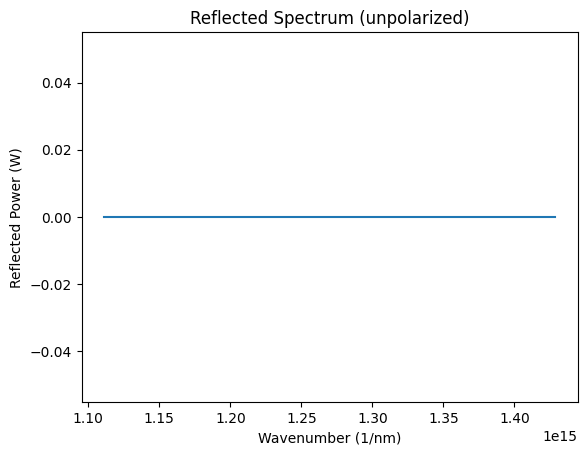

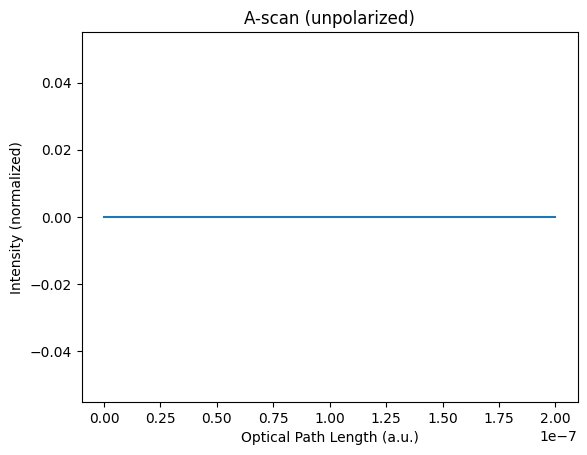

C:\Users\esteb\AppData\Local\Temp\ipykernel_31112\3281890368.py:112: RuntimeWarning: invalid value encountered in divide
  ascan /= np.max(ascan)


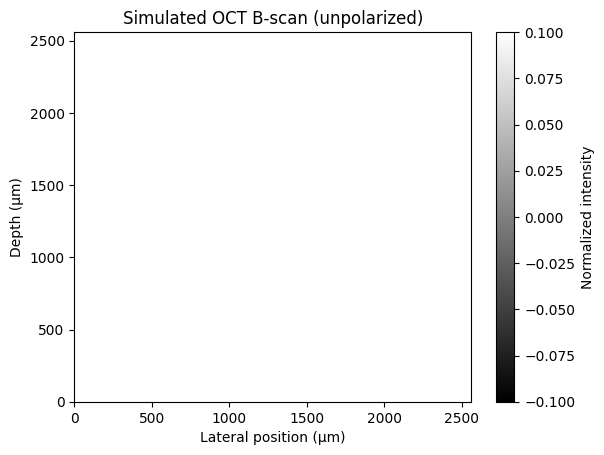

In [15]:
sim = OCTSimulator()
sim.run_simulation()
sim.plot_reflected_spectrum()
sim.compute_A_scan()
sim.simulate_B_scan( n_lateral=512, n_depth=512, dx=5e-6)

